In [1]:
# import packages and libraries

#import osmnx as ox
import geopandas as gpd
from pathlib import Path
import folium 


# init
@authors: [Alexandre Pereira Santos](alexandre.santos(at)lmu.de) & [Charlotta Mirbach](c.mirbach@lmu.de)

## data
- maximum flooded area (binarized)
- municipalities Rio grande do Sul (Brazil)

## tasks
- generate polygons for affected municipalities
- download OSM building for each affected municipality
- identify buildings within flooded area
- export to individual municipality buildings datasets


## functions

In [2]:
def osm_import_buildings(roi):
    # convert to epsg 4326
    roi_coords = roi.to_crs(epsg='4326').envelope

    # list key-value pairs for tags
    # Wiki url: https://wiki.openstreetmap.org/wiki/Key:building
    tags = {'building': True, 'source': True}  # Include 'source' column in tags

    # select relevant columns
    col_list = ['osmid', 'name', 'source', 'geometry', 'building']  # Include 'source' column in col_list

    # load buildings for bbox
    buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
                                        south=roi_coords.bounds.values[0][1],
                                        west=roi_coords.bounds.values[0][0],
                                        east=roi_coords.bounds.values[0][2],
                                        tags=tags)

    buildings.reset_index(inplace=True)

    # filter out the wrong geometries (not polygons) and element types (not 'way')
    buildings = buildings.loc[(buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])) & (buildings.element_type == 'way'), col_list]

    # convert crs to match roi
    buildings.to_crs(roi.crs, inplace=True)

    # clip geometries to roi
    clipped_gdf = gpd.clip(buildings, mask=roi, keep_geom_type=True)
    
    # return
    return clipped_gdf


## preprocessing

### load input data

In [4]:
#input flooded area vector 

flood_path = Path('../data/processed/')
flood_file = 'HYD_maximum_flood_area_2024_binary_A.shp' 
flood_gdf = gpd.read_file(flood_path/flood_file)
flood_gdf.drop(['gridcode','area'], axis=1, inplace=True)

# import the municipality boundaries
mun_path = Path('../data/external/')
mun_file = 'LIM_RS_municipalites_2022_A.shp'
mun_gdf = gpd.read_file(mun_path/mun_file)
mun_gdf = mun_gdf[(mun_gdf['NM_MUN']!='Lagoa dos Patos')]

#import building footprints
foot_path = Path('../../../Dropbox/x/PostDoc/02 colab and other/24 05 RS Floods/UFRGS/DADOS/Zenodo/V05/')
foot_file = 'insumos_googlebuildings_edificacoes_rhguaiba.gpkg'
foot_gdf = gpd.read_file(foot_path/foot_file, layer = 'rhguaiba_google_buildings')
foot_gdf.to_crs(flood_gdf.crs, inplace=True)

print('Flood CRS:', flood_gdf.crs,', Municipality CRS:', mun_gdf.crs, 'Buildings CRS:', foot_gdf.crs)

Flood CRS: EPSG:32722 , Municipality CRS: EPSG:32722 Buildings CRS: EPSG:4326


In [6]:
foot_gdf.to_crs(flood_gdf.crs, inplace=True)

### joining gdfs

In [7]:
join_gdf = foot_gdf.sjoin(mun_gdf, how='inner', predicate="within")
#affected_mun = join_gdf[join_gdf['index_right'].notna()].dissolve('NM_MUN') #.index_right.dropna(axis=0, subset=['index_right'], inplace=True)
#affected_mun.reset_index(inplace=True)
#affected_mun

### check join consistency

In [16]:
foot_gdf.head()

,latitude,longitude,area_in_meters,confidence,full_plus_code,geometry
0,-28.848039,-51.572102,27.0563,0.6875,583C5C2H+Q5JG,"POLYGON ((444198.500 6808713.500, 444198.500 6..."
1,-30.026502,-51.051474,84.7454,0.7986,48XCXWFX+9CRX,"POLYGON ((495044.173 6678274.812, 495043.362 6..."
2,-28.805628,-51.295699,216.0186,0.8980,583C5PV3+PPVW,"POLYGON ((471152.134 6813507.314, 471155.542 6..."
3,-29.346574,-51.385515,7.1515,0.7107,582CMJ37+9QH4,"POLYGON ((462577.930 6753555.721, 462575.757 6..."
4,-30.667396,-51.931613,109.6640,0.8104,48XC83M9+29R3,"POLYGON ((410755.858 6606894.732, 410746.009 6..."


In [9]:
print(join_gdf.shape, foot_gdf.shape)

(5847115, 11) (5857714, 6)


In [27]:
foot_len = len(foot_gdf.full_plus_code.unique())

In [28]:
foot_len - foot_gdf.shape[0] # full_plus_code is not unique, but repeats in exceptional cases

-56

In [12]:
join_gdf.full_plus_code.isna().describe() # there are no NA values in the full_plus_code in the joined df, though

count     5847115
unique          1
top         False
freq      5847115
Name: full_plus_code, dtype: object

In [29]:
join_full_len = len(join_gdf.full_plus_code.unique())

In [30]:
join_full_len - join_gdf.shape[0] # full_plus_code repeats in the same way it did for the foot_gdf, minus 1

-55

In [34]:
print('there are', foot_gdf.shape[0] - join_gdf.shape[0], 'less observations in the joined df than in the footprints df', 
      'this means', (foot_gdf.shape[0] - join_gdf.shape[0])/foot_gdf.shape[0] * 100, '%')

there are 10599 less observations in the joined df than in the footprints df this means 0.18094089264173704 %


### get bounding box for each municipality

<Axes: >

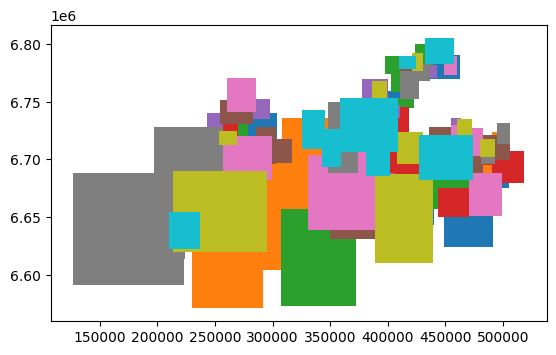

In [6]:
# extract a Bbox from each affected_mun feature
affected_mun_env =  affected_mun
affected_mun_env.geometry = affected_mun_env.envelope
affected_mun_env.plot('NM_MUN')

## get OSM data

## load buildings for each municipality

In [13]:
# process building data in batches
def process_osm_data(geo_df, batch_size=10, path='output_path'):
    path = Path(path)
    path.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    
    for i in range(0, len(geo_df), batch_size):
        batch = geo_df.iloc[i:i+batch_size]
        for _, mun in batch.iterrows():
            roi_file = path / f'LOC_{mun.NM_MUN}_buildings_OSM_2024_L.shp'
            
            # Check if the file already exists
            if roi_file.exists():
                print(f'Skipping {roi_file} as it already exists.')
                continue  # Skip to the next iteration if file exists
            
            roi_gdf = gpd.GeoDataFrame(geometry=[mun.geometry], crs=geo_df.crs)
            roi_buildings = osm_import_buildings(roi_gdf)
            roi_buildings.to_file(roi_file)
            print(f'Processed and saved: {roi_file}')



In [15]:
# apply function
mun_gdf = affected_mun_env  # gdf with affected areas
process_osm_data(mun_gdf, batch_size=10, path='../data/processed/')

Skipping ..\data\processed\LOC_Agudo_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Alvorada_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Arroio do Meio_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Arroio dos Ratos_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Barra do Ribeiro_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Bento Gonçalves_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Bom Retiro do Sul_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Butiá_buildings_OSM_2024_L.shp as it already exists.
Skipping ..\data\processed\LOC_Cachoeira do Sul_buildings_OSM_2024_L.shp as it already exists.


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Cachoeirinha_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Campo Bom_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Candelária_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Canoas_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Capela de Santana_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Caçapava do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Charqueadas_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Colinas_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Cotiporã_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Cruzeiro do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Dona Francisca_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Doutor Ricardo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Eldorado do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Encantado_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Encruzilhada do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Esteio_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Estrela_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Faxinal do Soturno_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Formigueiro_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Forquetinha_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_General Câmara_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Gravataí_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Guaíba_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],


Processed and saved: ..\data\processed\LOC_Harmonia_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],


Processed and saved: ..\data\processed\LOC_Ibarama_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Ivorá_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Lajeado_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Marques de Souza_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Minas do Leão_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Monte Belo do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Montenegro_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Muçum_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Nova Palma_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Nova Santa Rita_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Novo Cabrais_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Novo Hamburgo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Pantano Grande_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Paraíso do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Pareci Novo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Passo do Sobrado_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Pinhal Grande_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Pinto Bandeira_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Porto Alegre_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Portão_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Restinga Sêca_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Rio Pardo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Roca Sales_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Santa Cruz do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Santa Margarida do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Santa Maria_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Santa Tereza_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Sapiranga_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Sapucaia do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Gabriel_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Jerônimo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São João do Polêsine_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Leopoldo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Sebastião do Caí_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Sepé_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_São Valentim do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions ha

Processed and saved: ..\data\processed\LOC_Taquari_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Travesseiro_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Triunfo_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Vale Verde_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Vale do Sol_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Venâncio Aires_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Vera Cruz_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Veranópolis_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],
C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Processed and saved: ..\data\processed\LOC_Vespasiano Corrêa_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Temp\ipykernel_12776\3109598972.py:13: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north=roi_coords.bounds.values[0][3],


Processed and saved: ..\data\processed\LOC_Vila Nova do Sul_buildings_OSM_2024_L.shp


C:\Users\charl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\tools\clip.py:67: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


### spatially join buildings with flooded area

<Axes: >

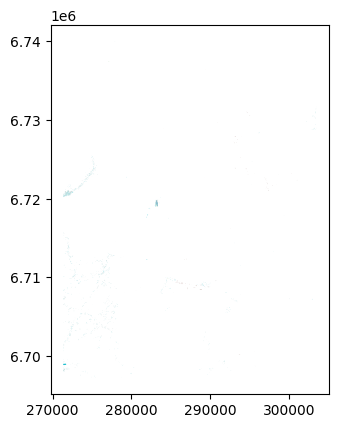

In [18]:
mun_file_list = list(Path('../data/processed').glob('LOC_*_buildings_OSM_2024_L.shp'))
mun_gdf_list = []
mun_gdf_dict = {}

AOI_path = Path('../data/processed/')

for file in mun_file_list: 
    gdp_name = file.stem.replace(' ', '_').replace('.shp', '')
    mun_gdf_list.append(gdp_name)

for i in range(len(mun_file_list)):
    mun_gdf_dict[mun_gdf_list[i]] = gpd.read_file(mun_file_list[i])




In [21]:
mun_gdf_dict
mun_file_list

[WindowsPath('../data/processed/LOC_Agudo_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Alvorada_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Arroio do Meio_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Arroio dos Ratos_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Barra do Ribeiro_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Bento Gonçalves_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Bom Retiro do Sul_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Butiá_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Cachoeira do Sul_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Cachoeirinha_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Campo Bom_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Candelária_buildings_OSM_2024_L.shp'),
 WindowsPath('../data/processed/LOC_Canoas_buildings_OSM_2024_L.shp'),
 Windo

<Axes: >

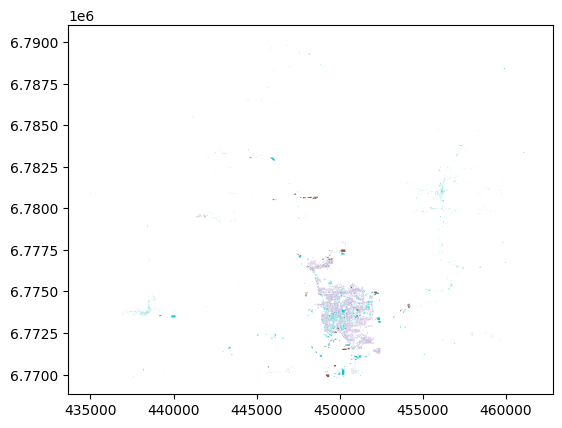

In [27]:
mun_gdf_dict[mun_gdf_list[5]].plot('building') # plot buildings in a municipality

In [28]:
joined_gdf_list = []
affected_gdf_list = []
joined_gdf_dict = {}
affected_gdf_dict = {}

for i in range(len(mun_gdf_list)):
    print(i, mun_gdf_list[i],mun_gdf_dict[mun_gdf_list[i]].shape)
    join_gdf_name =  mun_gdf_list[i] + '_join'
    joined_gdf_list.append(join_gdf_name)
    affected_gdf_name =  mun_gdf_list[i] + '_affected'
    affected_gdf_list.append(affected_gdf_name)

print(joined_gdf_list)

0 LOC_Agudo_buildings_OSM_2024_L (5777, 5)
1 LOC_Alvorada_buildings_OSM_2024_L (11648, 5)
2 LOC_Arroio_do_Meio_buildings_OSM_2024_L (11902, 5)
3 LOC_Arroio_dos_Ratos_buildings_OSM_2024_L (208, 5)
4 LOC_Barra_do_Ribeiro_buildings_OSM_2024_L (2092, 5)
5 LOC_Bento_Gonçalves_buildings_OSM_2024_L (16571, 5)
6 LOC_Bom_Retiro_do_Sul_buildings_OSM_2024_L (97, 5)
7 LOC_Butiá_buildings_OSM_2024_L (275, 5)
8 LOC_Cachoeira_do_Sul_buildings_OSM_2024_L (4383, 5)
9 LOC_Cachoeirinha_buildings_OSM_2024_L (2571, 5)
10 LOC_Campo_Bom_buildings_OSM_2024_L (895, 5)
11 LOC_Candelária_buildings_OSM_2024_L (1395, 5)
12 LOC_Canoas_buildings_OSM_2024_L (6613, 5)
13 LOC_Capela_de_Santana_buildings_OSM_2024_L (1567, 5)
14 LOC_Caçapava_do_Sul_buildings_OSM_2024_L (7058, 5)
15 LOC_Charqueadas_buildings_OSM_2024_L (108, 5)
16 LOC_Colinas_buildings_OSM_2024_L (6526, 5)
17 LOC_Cotiporã_buildings_OSM_2024_L (935, 5)
18 LOC_Cruzeiro_do_Sul_buildings_OSM_2024_L (5593, 5)
19 LOC_Dona_Francisca_buildings_OSM_2024_L (1619, 5

In [29]:
# joining the segments for each municipality

for i in range(len(joined_gdf_list)):
    joined_gdf_dict[joined_gdf_list[i]] = mun_gdf_dict[mun_gdf_list[i]].sjoin(flood_gdf,how='left')
    affected_gdf_dict[affected_gdf_list[i]] = joined_gdf_dict[joined_gdf_list[i]][joined_gdf_dict[joined_gdf_list[i]]['index_right'].notna()] #.dissolve('osmid').reset_index(inplace=True)